In [ ]:
#@title Copyright 2020 The Cirq Developers
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Textbook algorithms in Cirq

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/textbook_algorithms"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/experiments/textbook_algorithms.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/experiments/textbook_algorithms.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/experiments/textbook_algorithms.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In this notebook we'll run through some Cirq implementations of some of the standard algorithms that one encounters in an introductory quantum computing course. In particular, we will discuss the quantum teleportation algorithm, quantum Fourier transform, phase estimation algorithm, and Grover's algorithm. The discussion here is expanded from examples found in the [Cirq examples](https://github.com/quantumlib/Cirq/tree/main/examples) directory.

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    import cirq
    print("installed cirq.")

installing cirq...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.2 MB/s eta 0:00:0

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np

## Quantum teleportation

Quantum teleportation is a process by which a quantum state can be transmitted by sending only two classical bits of information. This is accomplished by pre-sharing an entangled state between the sender (Alice) and the receiver (Bob). This entangled state allows the receiver (Bob) of the two classical bits of information to possess a qubit with the same state as the one held by the sender (Alice).

In the cell below, we define a function which implements the circuit for quantum teleportation. This function inputs a gate which prepares the *message qubit* in some state to transmit from Alice to Bob.

> For more background on quantum teleportation or to see the mathematics of why it works, check out [the original paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895) or the [Wikipedia page](https://en.wikipedia.org/wiki/Quantum_teleportation).

In [ ]:
def make_quantum_teleportation_circuit(gate):
    """Returns a circuit for quantum teleportation.

    This circuit 'teleports' a random qubit state prepared by
    the input gate from Alice to Bob.
    """
    circuit = cirq.Circuit()

    # Get the three qubits involved in the teleportation protocol.
    msg = cirq.NamedQubit("Message")
    alice = cirq.NamedQubit("Alice")
    bob = cirq.NamedQubit("Bob")

    # The input gate prepares the message to send.
    circuit.append(gate(msg))

    # Create a Bell state shared between Alice and Bob.
    circuit.append([cirq.H(alice), cirq.CNOT(alice, bob)])

    # Bell measurement of the Message and Alice's entangled qubit.
    circuit.append([cirq.CNOT(msg, alice), cirq.H(msg), cirq.measure(msg, alice)])

    # Uses the two classical bits from the Bell measurement to recover the
    # original quantum message on Bob's entangled qubit.
    circuit.append([cirq.CNOT(alice, bob), cirq.CZ(msg, bob)])

    return circuit

Now, we define a gate to prepare the message qubit in some state, then visualize the teleportation circuit.

In [ ]:
"""Visualize the teleportation circuit."""
# Gate to put the message qubit in some state to send.
gate = cirq.X ** 0.25

# Create the teleportation circuit.
circuit = make_quantum_teleportation_circuit(gate)
print("Teleportation circuit:\n")
print(circuit)

As discussed, at the end of the circuit, Bob's qubit will be the state of the message qubit. We can verify this by simulating the circuit. First, we check what the state of the message qubit is given the above `gate`.

In [ ]:
"""Display the Bloch vector of the message qubit."""
message = cirq.Circuit(gate.on(cirq.NamedQubit("Message"))).final_state_vector()
message_bloch_vector = cirq.bloch_vector_from_state_vector(message, index=0)
print("Bloch vector of message qubit:")
print(np.round(message_bloch_vector, 3))

Now we simulate the entire teleportation circuit and check what the final state of Bob's qubit is.

In [ ]:
"""Simulate the teleportation circuit and get the final state of Bob's qubit."""
# Get a simulator.
sim = cirq.Simulator()

# Simulate the teleportation circuit.
result = sim.simulate(circuit)

# Get the Bloch vector of Bob's qubit.
bobs_bloch_vector = cirq.bloch_vector_from_state_vector(result.final_state_vector, index=1)
print("Bloch vector of Bob's qubit:")
print(np.round(bobs_bloch_vector, 3))

# Verify they are the same state!
np.testing.assert_allclose(bobs_bloch_vector, message_bloch_vector, atol=1e-6)

As we can see, the final state of Bob's qubit is the same as the initial state of the message qubit! One can change the `gate` above and re-run the protocol. The final state of Bob's qubit will always be the initial state of the message qubit.

## Quantum Fourier transform

This section provides an overview of the quantum Fourier transform which we use in the next section for the phase estimation algorithm.

### Overview of the quantum Fourier transform

We'll start out by reminding ourselves what the [quantum Fourier transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform) does, and how it should be constructed.

Suppose we have an $n$-qubit state $|x\rangle$ where $x$ is an integer in the range $0$ to $2^{n}-1$. (That is, $|x\rangle$ is a computational basis state.) The quantum Fourier transform (QFT) performs the following operation:

$$
\text{QFT}|x\rangle = \frac{1}{2^{n/2}} \sum_{y=0}^{2^n-1} e^{2\pi i y x/2^n} |y\rangle.
$$

> *Note*: The QFT maps from the computational basis to the frequency basis.

Though it may not be obvious at first glance, the QFT is actually a unitary transformation. As a matrix, the QFT is given by

$$
\text{QFT} = \begin{bmatrix}
1 & 1 & 1& \cdots &1 \\
1 & \omega & \omega^2& \cdots &\omega^{2^n-1} \\
1 & \omega^2 & \omega^4& \cdots &\omega^{2(2^n-1)}\\
\vdots &\vdots &\vdots &\ddots &\vdots \\
1 &\omega^{2^n-1} &\omega^{2(2^n-1)} &\cdots &\omega^{(2^n-1)(2^n-1)},
\end{bmatrix}
$$

where $\omega = e^{2\pi i /2^n}$.


If you believe that the QFT is unitary, then you'll also notice from the matrix form that its inverse is given by a similar expression but with complex-conjugated coefficients:

$$
\text{QFT}^{-1}|x\rangle = \frac{1}{2^{n/2}} \sum_{y=0}^{2^n-1} e^{-2\pi i y x/2^n} |y\rangle.
$$

The construction of the QFT as a circuit follows a simple recursive form, though fully justifying it will take us too far from the main goal of this notebook. We really only need to know what the circuit looks like, and for that we can look at the following diagram:

![QFT Circuit](https://upload.wikimedia.org/wikipedia/commons/6/61/Q_fourier_nqubits.png)

Here, $x_j$ represents the $j$th bit of the input $x$. The most significant bit is $x_1$ and the least significant bit is $x_n$ so that

$$
x = \sum_{j=0}^{n-1} x_{j+1}2^j.
$$

As usual, $H$ is the Hadamard gate. The Controlled-$R_j$ gates are phase gates similar to the Controlled-$Z$ gate. In fact, for us it will be useful to just think of them as fractional powers of Controlled-$Z$ gates:

$$
CR_j = CZ^{\large 1/2^{j-1}}
$$

Finally, on the far right of the above diagram we have the output representing the bits of $y$. The only difference between the left and right side is that the output bits are in *reversed order*: the most significant bit of $y$ is on the bottom and the least significant bit of $y$ is on the top. One can reverse this by including Swap gates at the end of the circuit.

### Quantum Fourier transform as a circuit

Let's define a generator which produces the QFT circuit. It should accept a list of qubits as input and `yield`s the gates to construct the QFT in the right order. A useful observation is that the QFT circuit "repeats" smaller versions of itself as you move from left to right across the diagram.

In [ ]:
def make_qft(qubits):
    """Generator for the QFT on a list of qubits.

    For four qubits, the answer is:

                          ┌───────┐   ┌────────────┐   ┌───────┐
    0: ───H───@────────@───────────@───────────────────────────────────────
              │        │           │
    1: ───────@^0.5────┼─────H─────┼──────@─────────@──────────────────────
                       │           │      │         │
    2: ────────────────@^0.25──────┼──────@^0.5─────┼─────H────@───────────
                                   │                │          │
    3: ────────────────────────────@^(1/8)──────────@^0.25─────@^0.5───H───
                      └───────┘   └────────────┘   └───────┘
    """
    # Your code here!

#### Solution

In [ ]:
def make_qft(qubits):
    """Generator for the QFT on a list of qubits."""
    qreg = list(qubits)
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (1 / 2 ** (i + 1)))(qubit, q_head)

We can check the solution agrees with the above diagram by printing it out for a small number of qubits.

In [ ]:
"""Visually check the QFT circuit."""
qubits = cirq.LineQubit.range(4)
qft = cirq.Circuit(make_qft(qubits))
print(qft)

                  ┌───────┐   ┌────────────┐   ┌───────┐
0: ───H───@────────@───────────@───────────────────────────────────────
          │        │           │
1: ───────@^0.5────┼─────H─────┼──────@─────────@──────────────────────
                   │           │      │         │
2: ────────────────@^0.25──────┼──────@^0.5─────┼─────H────@───────────
                               │                │          │
3: ────────────────────────────@^(1/8)──────────@^0.25─────@^0.5───H───
                  └───────┘   └────────────┘   └───────┘


### Quantum Fourier transform as an operation

The QFT is such a common subroutine that it is actually a pre-defined gate/operation in Cirq. One can use `cirq.QuantumFourierTransformGate` to get the gate or the helper function `cirq.qft` with a sequence of qubits to get the operation.

In [ ]:
"""Use the built-in QFT in Cirq."""
qft_operation = cirq.qft(*qubits, without_reverse=True)
qft_cirq = cirq.Circuit(qft_operation)
print(qft_cirq)

The function `cirq.qft` has the optional argument `without_reverse` which specifies whether or not to reverse the order of the bits at the end of the circuit. We can confirm the `make_qft` function we defined performs the same transformation as the built-in `cirq.qft` with the following test.

In [ ]:
"""Check equality of the 'manual' and 'built-in' QFTs."""
np.testing.assert_allclose(cirq.unitary(qft), cirq.unitary(qft_cirq))

### Inverse quantum Fourier transform as a circuit

As mentioned, the only difference between the QFT and inverse QFT is the sign of the exponent of the controlled rotations. Using the `make_qft` function as a guide, complete the `make_qft_inverse` function below.

In [ ]:
def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits.

    For four qubits, the answer is:

                       ┌────────┐   ┌──────────────┐   ┌────────┐
    0: ───H───@─────────@────────────@───────────────────────────────────────────×───
              │         │            │                                           │
    1: ───────@^-0.5────┼──────H─────┼───────@──────────@────────────────────×───┼───
                        │            │       │          │                    │   │
    2: ─────────────────@^-0.25──────┼───────@^-0.5─────┼──────H────@────────×───┼───
                                     │                  │           │            │
    3: ──────────────────────────────@^(-1/8)───────────@^-0.25─────@^-0.5───H───×───
                       └────────┘   └──────────────┘   └────────┘
    """
    # Your code here!

#### Solution

In [7]:
def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits."""
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

We can check the solution agrees with the above diagram by printing it out for a small number of qubits.

In [8]:
"""Visually check the inverse QFT circuit."""
qubits = cirq.LineQubit.range(4)
iqft = cirq.Circuit(make_qft_inverse(qubits))
print(iqft)

                   ┌────────┐   ┌──────────────┐   ┌────────┐
0: ──────────────────────────────@──────────────────@───────────@────────H───
                                 │                  │           │
1: ─────────────────@────────────┼───────@──────────┼──────H────@^-0.5───────
                    │            │       │          │
2: ───────@─────────┼──────H─────┼───────@^-0.5─────@^-0.25──────────────────
          │         │            │
3: ───H───@^-0.5────@^-0.25──────@^(-1/8)────────────────────────────────────
                   └────────┘   └──────────────┘   └────────┘


### Inverse quantum Fourier transform as an operation

The function `cirq.qft` can be used with the optional argument `inverse=True` to return an inverse QFT operation as shown below.

In [ ]:
"""Use the built-in inverse QFT in Cirq."""
iqft_operation = cirq.qft(*qubits, inverse=True, without_reverse=True)
iqft_cirq = cirq.Circuit(iqft_operation)
print(iqft_cirq)

As above, we can check the `make_qft_inverse` function we defined performs the same transformation as the built-in Cirq function.

In [ ]:
"""Check equality of the 'manual' and 'built-in' inverse QFTs."""
np.testing.assert_allclose(cirq.unitary(iqft), cirq.unitary(iqft_cirq))

## Phase estimation

As an application of our quantum Fourier transform circuit, we'll implement the [phase estimation](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm) algorithm. The phase estimation algorithm estimates the eigenvalues of a unitary operator and uses the inverse QFT as a subroutine. The total circuit that we are going to implement is shown below.

>![Phase Estimation](https://upload.wikimedia.org/wikipedia/commons/a/a5/PhaseCircuit-crop.svg)

Suppose we have a unitary operator $U$ with eigenvector $|\psi\rangle$ and eigenvalue $\exp(2\pi i \theta)$. (Every eigenvalue of a unitary can be written this way.) Our objective is to get an $n$-bit approximation to $\theta$. The first step is to construct the state

$$
|\Phi\rangle = \frac{1}{2^{n/2}}\sum_{y=0}^{2^{n-1}} e^{2\pi i y \theta}|y\rangle.
$$

This looks very similar to the output of the QFT applied to the state $|2^n\theta\rangle$, except for the fact that $2^n\theta$ may not be an integer. If $2^n\theta$ *were* an integer, then we would apply the inverse QFT and measure the qubits to read off the binary representation of $2^n\theta$. Even if $2^n\theta$ is not an integer, we can still perform the same procedure and the result will be a sequence of bits that, with high probability, gives an $n$-bit approximation to $\theta$. We just have to repeat the procedure a few times to be sure of the answer.

Since we've already constructed the inverse QFT, all we really have to do is figure out how to construct the state $|\Phi\rangle$. This is accomplished by the first part of the circuit pictured above. We begin by applying $H^{\otimes n}$ to the state $|0\rangle$, creating an equal superposition over all basis states:

$$
H^{\otimes n} |0\rangle = \frac{1}{2^{n/2}}\sum_{y=0}^{2^n-1}|y\rangle.
$$

Now we need to insert the correct phase coefficients. This is done by a sequence of Controlled-$U^k$ operations, where the qubits of $y$ are the controls and the $U^k$ operations act on $|\psi \rangle$.

Let's try to implement this part of the procedure in Cirq, and then put it together with the inverse QFT from above. For the gate $U$ we'll pick the single-qubit operation

$$
U = Z^{2\theta} = \begin{bmatrix}
1 & 0 \\
0 & e^{2\pi i \theta }
\end{bmatrix}
$$

for $\theta \in [0,1)$. This is just for simplicity and ease of testing. You are invited to write an implementation that accepts an arbitrary $U$.

In [ ]:
"""Set up the unitary and number of bits to use in phase estimation."""
# Value of θ which appears in the definition of the unitary U above.
# Try different values.
theta = 0.234

# Define the unitary U.
U = cirq.Z ** (2 * theta)

# Accuracy of the estimate for theta. Try different values.
n_bits = 3

Now we can build the first part of the circuit (up until the inverse QFT) for phase estimation.

In [ ]:
"""Build the first part of the circuit for phase estimation."""
# Get qubits for the phase estimation circuit.
qubits = cirq.LineQubit.range(n_bits)
u_bit = cirq.NamedQubit('u')

# Build the first part of the phase estimation circuit.
phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

for i, bit in enumerate(qubits):
    phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - i - 1)))

print(phase_estimator)

The next step is to perform the inverse QFT on the estimation qubits and measure them.

In [ ]:
"""Build the last part of the circuit (inverse QFT) for phase estimation."""
# Do the inverse QFT.
phase_estimator.append(make_qft_inverse(qubits[::-1]))

# Add measurements to the end of the circuit
phase_estimator.append(cirq.measure(*qubits, key='m'))
print(phase_estimator)

The initial state for `u_bit` is the $|0\rangle$ state, but the phase for this state is trivial with the operator we chose. Inserting a Pauli $X$ operator at the beginning of the circuit changes this to the $|1\rangle$ state, which has the nontrivial $\theta$ phase.

In [ ]:
"""Set the input state of the eigenvalue register."""
# Add gate to change initial state to |1>.
phase_estimator.insert(0, cirq.X(u_bit))

print(phase_estimator)

Now we can instantiate a simulator and make measurements of the estimation qubits. Let the values of these measured qubits be $a_j \in \{0, 1\}$. Then our $n$-bit approximation for $\theta$ is given by

$$
\theta \approx \sum_{j=0}^n a_j2^{-j}.
$$

We'll perform this conversion from bit values to $\theta$-values and then print the results.

In [ ]:
"""Simulate the circuit and convert from measured bit values to estimated θ values."""
# Simulate the circuit.
sim = cirq.Simulator()
result = sim.run(phase_estimator, repetitions=10)

# Convert from output bitstrings to estimate θ values.
theta_estimates = np.sum(2 ** np.arange(n_bits) * result.measurements['m'], axis=1) / 2**n_bits
print(theta_estimates)

When `n_bits` is small, we don't get a very accurate estimate. To test the accuracy of the estimate vs. `n_bits`, let's pack all this up into a single function that lets us specify $\theta$, the number of bits of accuracy we want in our approximation, and the number of repetitions of the algorithm to perform. For future purposes, let's also include an argument for the gate which acts on `u_bit` at the start of the circuit to prepare the eigenstate.

### Exercise: Define a function for phase estimation

You could just copy/paste from the previous cells, but it might be a useful exercise to write the whole thing from scratch without peeking.

In [ ]:
def phase_estimation(theta, n_bits, n_reps=10, prepare_eigenstate_gate=cirq.X):
    """Runs the phase estimate algorithm for unitary U=Z^{2θ} with n_bits qubits."""
    # Define qubit registers.
    qubits = cirq.LineQubit.range(n_bits)
    u_bit = cirq.NamedQubit('u')

    # Define the unitary U.
    U = cirq.Z ** (2 * theta)

    # Your code here!
    # ...

    # Gate to choose the initial state for the u_bit. Placing X here chooses the |1> state.
    phase_estimator.insert(0, prepare_eigenstate_gate.on(u_bit))

    # You code here!
    # theta_estimates = ...

    return theta_estimates

#### Solution

Here is a solution that just consists of what we did in previous cells all put together.

In [ ]:
def phase_estimation(theta, n_bits, n_reps=10, prepare_eigenstate_gate=cirq.X):
    # Define qubit registers.
    qubits = cirq.LineQubit.range(n_bits)
    u_bit = cirq.NamedQubit('u')

    # Define the unitary U.
    U = cirq.Z ** (2 * theta)

    # Start with Hadamards on every qubit.
    phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

    # Do the controlled powers of the unitary U.
    for i, bit in enumerate(qubits):
        phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - 1 - i)))

    # Do the inverse QFT.
    phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Add measurements.
    phase_estimator.append(cirq.measure(*qubits, key='m'))

    # Gate to choose the initial state for the u_bit. Placing X here chooses the |1> state.
    phase_estimator.insert(0, prepare_eigenstate_gate.on(u_bit))

    # Code to simulate measurements
    sim = cirq.Simulator()
    result = sim.run(phase_estimator, repetitions=n_reps)

    # Convert measurements into estimates of theta
    theta_estimates = np.sum(2**np.arange(n_bits)*result.measurements['m'], axis=1)/2**n_bits

    return theta_estimates

Now we can easily examine the accuracy of the estimate vs `n_bits`. We do so for a variety of values for `n_bits` in the following cell.

In [ ]:
"""Analyze convergence vs n_bits."""
# Set the value of theta. Try different values.
theta = 0.123456

max_nvals = 16
nvals = np.arange(1, max_nvals, step=1)

# Get the estimates at each value of n.
estimates = []
for n in nvals:
    estimate = phase_estimation(theta=theta, n_bits=n, n_reps=1)[0]
    estimates.append(estimate)

And now we make a plot of the $\theta$ estimates vs. the number of bits.

In [ ]:
"""Plot the results."""
plt.style.use("seaborn-v0_8-whitegrid")

plt.plot(nvals, estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of bits")
plt.ylabel(r"$\theta$");

#### Phase Estimation Without an Eigenstate

What if the input to the circuit was not an eigenstate of $U$ at all? We can always decompose such a state in the eigenbasis of $U$ as

$$
\sum_j \alpha_j|u_j\rangle
$$

where $U |u_j\rangle = e^{2 \pi i \theta_j} |u_j\rangle$. Then each time we run the circuit we will get an $n$-bit estimate of one of the $\theta_j$ chosen at random, and the probability of choosing a particular $\theta_j$ is given by $|\alpha_j|^2$.

One simple test of this is to modify our above code to pass the state

$$
|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}
$$

into the phase estimator for $Z^{2\theta}$. The state $|0\rangle$ has eigenvalue $1$ while the state $|1\rangle$ has eigenvalue $e^{2\pi i \theta_j}$. We can do this with the `prepare_eigenstate_gate` argument to the `phase_estimation_function`, as shown below.

In [ ]:
"""Run phase estimation without starting in an eigenstate."""
# Value of theta.
theta = 0.123456

# Number of qubits.
n = 4

# Run phase estimation starting in the state H|0⟩ = |+⟩.
res = phase_estimation(theta=theta, n_bits=n, n_reps=10, prepare_eigenstate_gate=cirq.H)
print(res)

Notice that roughly half of the measurements yielded the estimate $0$ (which corresponds to the eigenvalue $1$) and roughly half yield the estimate of `theta`. This is expected because the initial state $|+\rangle$ is an equal superposition of the two eigenstates of $U = Z^{2 \theta}$.

Often we won't be able to prepare an exact eigenstate of the operator $U$ we are interested in, so it's very useful to know about this feature of phase estimation. This is crucial for understanding [Shor's algorithm](https://en.wikipedia.org/wiki/Shor%27s_algorithm), for instance.

### Exercise: Quantum Fourier transform with unreversed output

As mentioned, the `cirq.qft` function has an argument `without_reverse` for whether or not to reverse the output bits. Add a similar argument to our `make_qft` function which does the same thing. You may want to consider using SWAP gates.

In [ ]:
def make_qft(qubits, without_reverse=True):
    """Generator for the QFT on a list of qubits."""
    qreg = list(qubits)
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (1 / 2 ** (i + 1)))(qubit, q_head)

    if not without_reverse:
      n = len(qubits)
      for i in range(0, n // 2):
        yield cirq.SWAP(qubits[i], qubits[n - i - 1])

In [ ]:
"""Visually check the QFT circuit."""
qubits = cirq.LineQubit.range(4)
qft = cirq.Circuit(make_qft(qubits, without_reverse=False))
print(qft)

                  ┌───────┐   ┌────────────┐   ┌───────┐
0: ───H───@────────@───────────@───────────────────────────────────────×───
          │        │           │                                       │
1: ───────@^0.5────┼─────H─────┼──────@─────────@──────────────────×───┼───
                   │           │      │         │                  │   │
2: ────────────────@^0.25──────┼──────@^0.5─────┼─────H────@───────×───┼───
                               │                │          │           │
3: ────────────────────────────@^(1/8)──────────@^0.25─────@^0.5───H───×───
                  └───────┘   └────────────┘   └───────┘


In [ ]:
"""Use the built-in QFT in Cirq."""
qft_operation = cirq.qft(*qubits, without_reverse=False)
qft_cirq = cirq.Circuit(qft_operation)
print(qft_cirq)

0: ───qft───
      │
1: ───#2────
      │
2: ───#3────
      │
3: ───#4────


In [ ]:
"""Check equality of the 'manual' and 'built-in' QFTs."""
np.testing.assert_allclose(cirq.unitary(qft), cirq.unitary(qft_cirq))

### Exercise: Phase estimation with arbitrary $U$

Try to implement the phase estimation algorithm in a way that an arbitrary gate $U$ can be supplied and tested. After you've done that, you can test the algorithm on some of your favorite two- or three-qubit gates.

In [9]:
from typing import List

def phase_estimation_U(U: cirq.Gate, n_bits: int, prepare_eigenstate_gate: cirq.Gate, n_reps=10):
    # Define qubit registers.
    qubits = cirq.LineQubit.range(n_bits)
    m = U.num_qubits()
    eigenvector = cirq.LineQubit.range(n_bits, n_bits + m)

    # Start with Hadamards on every qubit.
    phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

    # Do the controlled powers of the unitary U.
    for i, bit in enumerate(qubits):
        phase_estimator.append(cirq.ControlledGate(U, num_controls=1).on(bit, *eigenvector) ** (2 ** (n_bits - 1 - i)))

    # Do the inverse QFT.
    phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Add measurements.
    phase_estimator.append(cirq.measure(*qubits, key='m'))

    # Gate to choose the initial state for the eigenvector
    phase_estimator.insert(0, prepare_eigenstate_gate.on(*eigenvector))

    # Code to simulate measurements
    sim = cirq.Simulator()
    result = sim.run(phase_estimator, repetitions=n_reps)

    # Convert measurements into estimates of theta
    phase_estimates = np.sum(2**np.arange(n_bits)*result.measurements['m'], axis=1)/2**n_bits

    return phase_estimates

In [17]:
"""Analyze convergence vs n_bits."""
# Set the value of theta. Try different values.
theta = 0.3

max_nvals = 16
nvals = np.arange(1, max_nvals, step=1)

# Define the unitary U.
U = cirq.CZ ** (2 * theta)
# cirq.XX shits |00> to |11> which has eigenvalue e^{2\pi i\theta}

# Get the estimates at each value of n.
estimates = []
for n in nvals:
    estimate = phase_estimation_U(U, n_bits=n, prepare_eigenstate_gate=cirq.XX, n_reps=1)[0]
    estimates.append(estimate)

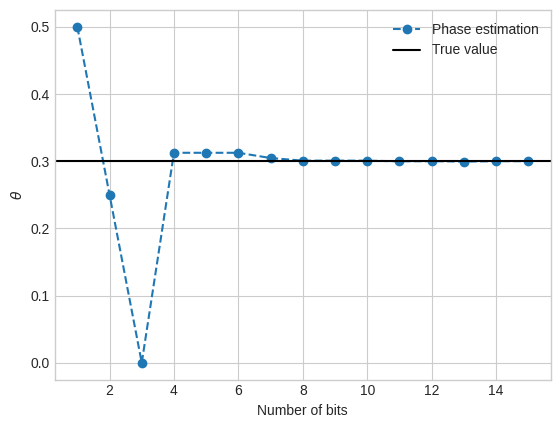

In [16]:
"""Plot the results."""
plt.style.use("seaborn-v0_8-whitegrid")

plt.plot(nvals, estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of bits")
plt.ylabel(r"$\theta$");

### Exercise: QFT and phase estimation with adjacency constraints

Often on a real machine we can't execute two-qubit gates between qubits that are not right next to each other. You'll have noticed that the circuits we defined above involves connections between many different pairs of qubits, which will likely not all be near each other when we try to run the circuit on an actual chip. See if you can modify the examples we went through above in such a way that Cirq validates them for use on the Sycamore chip.

## Grover's algorithm

Consider bitstrings of length $n$ and let $x' \in \{0, 1\}^{n}$ be a "marked" bitstring we wish to find. Grover's algorithm takes a black-box oracle implementing a function $f : \{0, 1\}^n \rightarrow \{0, 1\}$ defined by

$$
f(x) = 1\text{ if } x = x',~~~~ f(x) = 0 \text{ if } x \neq x'
$$

to find such a bitstring $x'$. Grover's algorithm uses $O(\sqrt{N}$) operations and $O(N\, \log N$) gates and succeeds with probability $p \geq 2/3$.

Below, we walk through a simple implementation of Grover's algorithm described in [this reference](https://arxiv.org/abs/1804.03719). This implementation only supports $n = 2$ (for which one application of the Grover iteration is enough).

First we define our qubit registers. We use $n = 2$ bits in one register and an additional ancilla qubit for phase kickback.

In [ ]:
"""Get qubits to use in the circuit for Grover's algorithm."""
# Number of qubits n.
nqubits = 2

# Get qubit registers.
qubits = cirq.LineQubit.range(nqubits)
ancilla = cirq.NamedQubit("Ancilla")

We now define a generator to yield the operations for the oracle. As discussed in the above reference, the oracle can be implemented by a Toffoli gate if all the bits in $x'$ are $1$. If some bits are $0$, we do an "open control" (control on the $|0\rangle$ state) for these bits. This can be accomplished by flipping every $0$ bit with $X$ gates, performing a Tofolli, then undoing the $X$ gates.

In [ ]:
def make_oracle(qubits, ancilla, xprime):
    """Implements the function {f(x) = 1 if x == x', f(x) = 0 if x != x'}."""
    # For x' = (1, 1), the oracle is just a Toffoli gate.
    # For a general x', we negate the zero bits and implement a Toffoli.

    # Negate zero bits, if necessary.
    yield (cirq.X(q) for (q, bit) in zip(qubits, xprime) if not bit)

    # Do the Toffoli.
    yield (cirq.TOFFOLI(qubits[0], qubits[1], ancilla))

    # Negate zero bits, if necessary.
    yield (cirq.X(q) for (q, bit) in zip(qubits, xprime) if not bit)

Now that we have a function to implement the oracle, we can construct a function to implement one round of Grover's iteration.

In [ ]:
def grover_iteration(qubits, ancilla, oracle):
    """Performs one round of the Grover iteration."""
    circuit = cirq.Circuit()

    # Create an equal superposition over input qubits.
    circuit.append(cirq.H.on_each(*qubits))

    # Put the output qubit in the |-⟩ state.
    circuit.append([cirq.X(ancilla), cirq.H(ancilla)])

    # Query the oracle.
    circuit.append(oracle)

    # Construct Grover operator.
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on(qubits[1]))
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    circuit.append(cirq.H.on(qubits[1]))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on_each(*qubits))

    # Measure the input register.
    circuit.append(cirq.measure(*qubits, key="result"))

    return circuit

We now select the bitstring $x'$ at random.

In [ ]:
"""Select a 'marked' bitstring x' at random."""
xprime = [random.randint(0, 1) for _ in range(nqubits)]
print(f"Marked bitstring: {xprime}")

And now create the circuit for Grover's algorithm.

In [ ]:
"""Create the circuit for Grover's algorithm."""
# Make oracle (black box)
oracle = make_oracle(qubits, ancilla, xprime)

# Embed the oracle into a quantum circuit implementing Grover's algorithm.
circuit = grover_iteration(qubits, ancilla, oracle)
print("Circuit for Grover's algorithm:")
print(circuit)

All that is left is to simulate the circuit and check if the sampled bitstring(s) match with the marked bitstring $x'$.

In [ ]:
"""Simulate the circuit for Grover's algorithm and check the output."""
# Helper function.
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

# Sample from the circuit a couple times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=10)

# Look at the sampled bitstrings.
frequencies = result.histogram(key="result", fold_func=bitstring)
print('Sampled results:\n{}'.format(frequencies))

# Check if we actually found the secret value.
most_common_bitstring = frequencies.most_common(1)[0][0]
print("\nMost common bitstring: {}".format(most_common_bitstring))
print("Found a match? {}".format(most_common_bitstring == bitstring(xprime)))

We see that we indeed found the marked bitstring $x'$. One can rerun these cells to select a new bitstring $x'$ and check that Grover's algorithm can again find it.